In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

#### In this notebook, we explore the idea that factor components are important for panel data models, and as a result TWFE based models have significant omitted variable bias. A direct way to demonstrate this idea is to extract the leading factor from the matrix of residuals of a TWFE regression, then show that i) it has predictive power on outcomes of a held-out set/is correlated on the regional level and ii) it is also correlated with the treatment assignment. We start with the CPS data and then perform similar procedures on DiD datasets used in some previous works.

## CPS Data

In [534]:
df = pd.read_csv('CPS.csv',sep=';')
Y_true_full = np.reshape(df['log_wage'].values, (40,-1))
Y_true_full = Y_true_full.T
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N_total,T_total = Y_true_full.shape

In [535]:
df

,state,year,log_wage,hours,urate,min_wage,open_carry,abort_ban
0,AK,1979,-0.759183,37.504,0.073,False,False,False
1,AL,1979,-2.269627,36.289,0.065,False,False,False
2,AR,1979,-2.225654,37.182,0.060,False,False,False
3,AZ,1979,-1.724803,38.692,0.045,False,False,False
4,CA,1979,-1.651739,36.578,0.060,False,False,False
...,...,...,...,...,...,...,...,...
1995,VT,2018,1.676063,38.760,0.027,True,True,True
1996,WA,2018,1.702448,36.485,0.033,True,False,True
1997,WI,2018,1.311645,35.916,0.009,False,True,False
1998,WV,2018,1.264739,36.563,0.055,False,True,False


In [536]:
Y_true_full.shape

(50, 40)

In [537]:
states = list(df['state'][:50])

## Treatment Vector

In [538]:
treatment = np.reshape(df['min_wage'].values, (40,-1))
treatment = treatment.T

In [539]:
np.argwhere(treatment==True)

array([[ 4, 39],
       [ 6, 39],
       [ 7, 39],
       [18, 39],
       [36, 39],
       [38, 39],
       [45, 39],
       [46, 39]])

In [540]:
Ds = np.argwhere(treatment==True)[:,0]
Ds

array([ 4,  6,  7, 18, 36, 38, 45, 46])

In [541]:
assignment_vector = np.zeros((N_total,))
assignment_vector[Ds] = 1

In [542]:
assignment_vector

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

## TWFE Regression with 1 Factor to Extract Unit Loadings

In [543]:
def TWFE_one_factor(Y, M, iters=50):
    units, times = Y.shape
    
    time_factors = np.ones((1,times))

    # polishing effect of OSQP results in not truly weighting by zero; use cp.sum_squares instead of
    #objective = cp.sum(cp.multiply(cp.square(Y-unit_factor-time_factor),W))
    
    # iterate between updating unit and time loadings
    for i in range(iters):
        
        unit_effect = cp.Variable((1,units))
        time_effect = cp.Variable((1,times))
        unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
        time_effects = cp.kron(np.ones((units,1)),time_effect)
        mu = cp.Variable()
        
        unit_loadings = cp.Variable((units,1))
        
        objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu-unit_loadings@time_factors,M))

        constraints = []

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
        unit_loadings = unit_loadings.value        
        
        unit_effect = cp.Variable((1,units))
        time_effect = cp.Variable((1,times))
        unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
        time_effects = cp.kron(np.ones((units,1)),time_effect)
        mu = cp.Variable()
        
        time_factors = cp.Variable((1,times))
        
        objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu-unit_loadings@time_factors,M))

        constraints = [cp.sum(time_factors)==times]

        prob = cp.Problem(cp.Minimize(objective),
                          constraints)
        prob.solve()
        time_factors = time_factors.value
        
        #print(unit_loadings)
        
    return unit_loadings, time_factors, unit_effect.value.T+time_effect.value+mu.value+unit_loadings.dot(time_factors)

In [544]:
#mask = np.ones(Y_true_full.shape)
np.random.seed(0)
mask = np.random.binomial(1, 0.5, size=(Y_true_full.shape))

In [545]:
unit_loadings, time_factors, predicted_values = TWFE_one_factor(Y_true_full, mask)
unit_loadings

array([[ 0.47708782],
       [-0.17939978],
       [-0.16849991],
       [-0.00490057],
       [ 0.04830506],
       [-0.21712853],
       [-0.22495004],
       [-0.29486785],
       [-0.06892138],
       [-0.16411762],
       [ 0.0127683 ],
       [-0.26529447],
       [-0.13640586],
       [-0.07945278],
       [-0.09948941],
       [-0.01814244],
       [-0.15906365],
       [-0.02075496],
       [-0.32198772],
       [-0.21593982],
       [-0.28123448],
       [-0.10732865],
       [-0.31482007],
       [-0.16552221],
       [-0.14683056],
       [-0.02740098],
       [-0.1109866 ],
       [-0.21031393],
       [-0.33164542],
       [-0.27151145],
       [-0.2390446 ],
       [ 0.04376678],
       [ 0.13439405],
       [-0.11572103],
       [-0.07903711],
       [ 0.15423335],
       [-0.00207743],
       [-0.1924836 ],
       [-0.26549437],
       [-0.17462156],
       [-0.35848404],
       [-0.05043927],
       [ 0.05257127],
       [ 0.05137095],
       [-0.15592946],
       [-0

## Heat Map

In [546]:
# regions = [['CT','ME','MA','NH','RI','VT'],['NJ','NY','PA','MD'],['IL','IN','MI','OH','WI'],
#            ['IA','KS','MN','MO','NE','ND','SD'],['FL','GA','NC','SC','VA','DE','WV'],['AL','KY','MS','TN'],
#           ['AR','LA','OK','TX'],['AZ','CO','ID','MT','NV','NM','UT','WY'],['AK','CA','HI','OR','WA']]

In [547]:
ordered_states = ['CT','ME','MA','NH','RI','VT','NJ','NY','PA','MD','IL','IN','MI','OH','WI','IA','KS','MN','MO',
           'NE','ND','SD','FL','GA','NC','SC','VA','DE','WV','AL','KY','MS','TN','AR','LA','OK','TX',
           'AZ','CO','ID','MT','NV','NM','UT','WY','AK','CA','HI','OR','WA']

In [548]:
index_mapping = {value: index for index, value in enumerate(states)} 
ordered_state_index = [index_mapping[state] for state in ordered_states]
ordered_state_index

[6,
 20,
 18,
 29,
 38,
 45,
 30,
 33,
 37,
 19,
 13,
 14,
 21,
 34,
 47,
 11,
 15,
 22,
 23,
 28,
 27,
 40,
 8,
 9,
 26,
 39,
 44,
 7,
 48,
 1,
 16,
 24,
 41,
 2,
 17,
 35,
 42,
 3,
 5,
 12,
 25,
 32,
 31,
 43,
 49,
 0,
 4,
 10,
 36,
 46]

In [549]:
ordered_loadings = unit_loadings[ordered_state_index,:]

In [550]:
ordered_loadings

array([[-0.22495004],
       [-0.28123448],
       [-0.32198772],
       [-0.27151145],
       [-0.26549437],
       [-0.35778793],
       [-0.2390446 ],
       [-0.11572103],
       [-0.1924836 ],
       [-0.21593982],
       [-0.07945278],
       [-0.09948941],
       [-0.10732865],
       [-0.07903711],
       [-0.34146023],
       [-0.26529447],
       [-0.01814244],
       [-0.31482007],
       [-0.16552221],
       [-0.33164542],
       [-0.21031393],
       [-0.35848404],
       [-0.06892138],
       [-0.16411762],
       [-0.1109866 ],
       [-0.17462156],
       [-0.15592946],
       [-0.29486785],
       [-0.1366978 ],
       [-0.17939978],
       [-0.15906365],
       [-0.14683056],
       [-0.05043927],
       [-0.16849991],
       [-0.02075496],
       [ 0.15423335],
       [ 0.05257127],
       [-0.00490057],
       [-0.21712853],
       [-0.13640586],
       [-0.02740098],
       [ 0.13439405],
       [ 0.04376678],
       [ 0.05137095],
       [ 0.05190977],
       [ 0

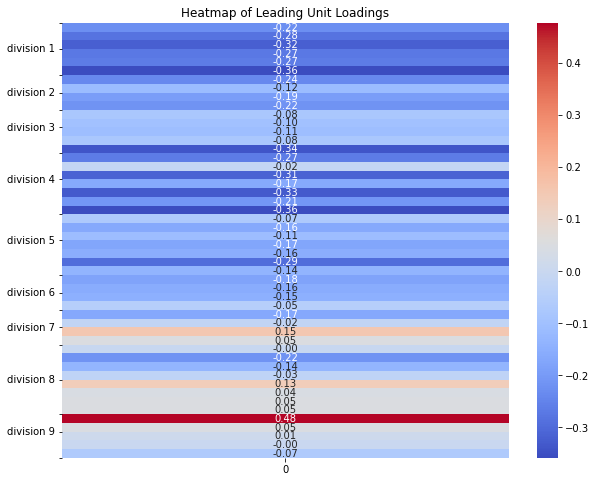

In [551]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(ordered_loadings, annot=True, cmap='coolwarm', fmt=".2f", yticklabels=ordered_states) 
plt.title('Heatmap of Leading Unit Loadings') 
plt.yticks(ticks=[0, 3, 6, 8, 10, 12, 15, 18, 22, 25, 29, 31, 33, 35, 37, 41, 45, 47, 50], labels=['','division 1', '', 'division 2', '', 'division 3', '',
                                                          'division 4', '', 'division 5', '', 'division 6', '',
                                                          'division 7', '', 'division 8', '', 'division 9', ''])
plt.show()

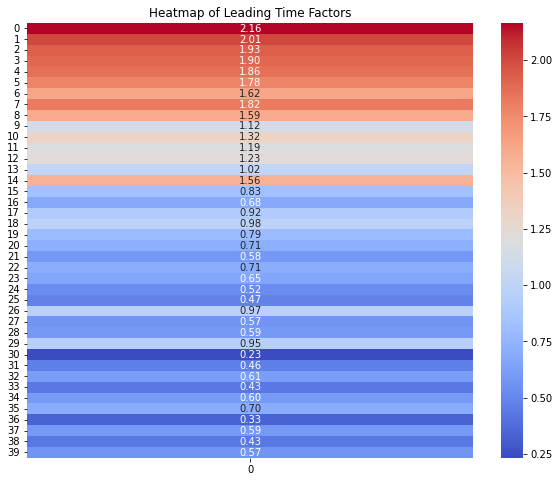

In [552]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(time_factors.T, annot=True, cmap='coolwarm', fmt=".2f", yticklabels=np.arange(40)) 
plt.title('Heatmap of Leading Time Factors') 
plt.show()

## MSE on Test Samples

### TWFE

In [553]:
def TWFE(Y, M):
    units, times = Y.shape
    unit_effect = cp.Variable((1,units))
    time_effect = cp.Variable((1,times))
    unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
    time_effects = cp.kron(np.ones((units,1)),time_effect)
    mu = cp.Variable()

    objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu,M))/np.sum(M)
    #objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects,M))/np.sum(M)

    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()
    
    return objective.value, unit_effect.value.T+time_effect.value+mu.value

In [554]:
_, predicted_values = TWFE(Y_true_full, mask)

In [555]:
np.sqrt(np.mean(np.square(Y_true_full[mask == 0]-predicted_values[mask == 0])))

0.13001274431507118

### TWFE Plus Unit Loading

In [556]:
def TWFE_plus_loading(Y, M, loading_factor):
    units, times = Y.shape
    unit_effect = cp.Variable((1,units))
    time_effect = cp.Variable((1,times))
    unit_effects = cp.kron(np.ones((times,1)),unit_effect).T
    time_effects = cp.kron(np.ones((units,1)),time_effect)
    loading_factor_coefficient = cp.Variable()
    mu = cp.Variable()

    #objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-mu-loading_factor_coefficient*loading_factor,M))/np.sum(M)
    objective = cp.sum_squares(cp.multiply(Y-unit_effects-time_effects-loading_factor_coefficient*loading_factor,M))/np.sum(M)
    constraints = []

    prob = cp.Problem(cp.Minimize(objective),
                      constraints)
    prob.solve()
    
    return objective.value, unit_effect.value.T+time_effect.value+loading_factor_coefficient.value*loading_factor

In [557]:
_, _, predicted_values = TWFE_one_factor(Y_true_full, mask)

In [558]:
np.sqrt(np.mean(np.square(Y_true_full[mask == 0]-predicted_values[mask == 0])))

0.11332625006652472

## Correlation with Treatment

In [559]:
model = LogisticRegression(penalty=None).fit(unit_loadings, assignment_vector)
pi = model.predict_proba(unit_loadings)[:,1]
model.coef_

array([[-3.90896028]])

In [563]:
unit_loadings_sm = sm.add_constant(unit_loadings)
logit_model = sm.Logit(assignment_vector, unit_loadings) 
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.640485
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   50
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            0
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                 -0.4567
Time:                        09:19:49   Log-Likelihood:                -32.024
converged:                       True   LL-Null:                       -21.983
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.4981      1.623      2.156      0.031       0.318       6.679


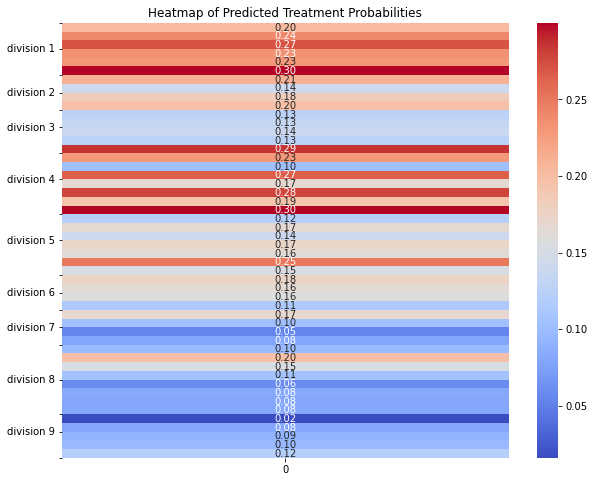

In [564]:
ordered_pi = np.array(pi[ordered_state_index])[:,np.newaxis]
plt.figure(figsize=(10, 8)) 
sns.heatmap(ordered_pi, annot=True, cmap='coolwarm', fmt=".2f", yticklabels=ordered_states) 
plt.title('Heatmap of Predicted Treatment Probabilities') 
#plt.yticks(ticks=[0, 5, 9], labels=['division 1','division 2', 'division 3'])
plt.yticks(ticks=[0, 3, 6, 8, 10, 12, 15, 18, 22, 25, 29, 31, 33, 35, 37, 41, 45, 47, 50], labels=['','division 1', '', 'division 2', '', 'division 3', '',
                                                          'division 4', '', 'division 5', '', 'division 6', '',
                                                          'division 7', '', 'division 8', '', 'division 9', ''])
plt.show()

## Unit Fixed Effects across Time

In [566]:
residuals = Y_true_full-np.mean(Y_true_full,axis=0)
indicator = np.zeros((T_total,))
indicator[20:] = 1
effects = []
stds = []
p_values = []
for i in range(N_total):
    model = sm.OLS(residuals[i,:], indicator).fit()
    print(model.summary())
    effects.append(model.params[0])
    stds.append(model.bse[0])
    p_values.append(model.pvalues[0])

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.063
Method:                 Least Squares   F-statistic:                              3.680
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0624
Time:                        09:20:05   Log-Likelihood:                         -35.645
No. Observations:                  40   AIC:                                      73.29
Df Residuals:                      39   BIC:                                      74.98
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [568]:
result = pd.DataFrame({'state': states, 'effct difference': effects, 'std': stds, 'p values': p_values})

In [569]:
result

,state,effct difference,std,p values
0,AK,0.256258,0.133585,6.241311e-02
1,AL,-0.150996,0.040907,6.809744e-04
2,AR,-0.236294,0.049481,2.536904e-05
3,AZ,0.074319,0.033125,3.061112e-02
4,CA,0.231960,0.070824,2.220110e-03
5,CO,0.229738,0.039112,7.752249e-07
6,CT,0.373815,0.066891,1.930645e-06
7,DE,0.239007,0.037372,1.463600e-07
8,FL,0.038430,0.016414,2.441892e-02
9,GA,0.039771,0.023139,9.357590e-02


In [570]:
result.round(4).to_csv('effect_difference.csv', index=False)

## WAGEPAN Dataset

In [571]:
#df_did = pd.read_stata('voting_cnty_clean.dta')
df_did = pd.read_stata('WAGEPAN.DTA')
pd.set_option('display.max_columns', None)

In [572]:
df_did

,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,poorhlth,hours,manuf,married,min,nrthcen,nrtheast,occ1,occ2,occ3,occ4,occ5,occ6,occ7,occ8,occ9,per,pro,pub,rur,south,educ,tra,trad,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
0,13,1980,0,0,1,0,0,1,0,0,0,2672,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.197540,0,0,0,0,0,0,0,1
1,13,1981,0,0,0,0,0,2,0,0,0,2320,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,14,0,0,1,1.853060,1,0,0,0,0,0,0,4
2,13,1982,0,0,1,0,0,3,0,0,0,2940,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.344462,0,1,0,0,0,0,0,9
3,13,1983,0,0,1,0,0,4,0,0,0,2960,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,14,0,0,0,1.433213,0,0,1,0,0,0,0,16
4,13,1984,0,0,0,0,0,5,0,0,0,3071,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,14,0,0,0,1.568125,0,0,0,1,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,0,0,1,0,8,0,0,0,2080,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,9,0,0,0,1.591879,0,0,1,0,0,0,0,64
4356,12548,1984,0,0,0,1,0,9,0,0,0,2080,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,9,0,0,1,1.212543,0,0,0,1,0,0,0,81
4357,12548,1985,0,0,0,1,0,10,0,0,0,2080,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,9,0,0,0,1.765962,0,0,0,0,1,0,0,100
4358,12548,1986,0,0,0,0,0,11,0,0,0,2080,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,9,0,0,1,1.745894,0,0,0,0,0,1,0,121


In [573]:
df_did.columns

Index(['nr', 'year', 'agric', 'black', 'bus', 'construc', 'ent', 'exper',
       'fin', 'hisp', 'poorhlth', 'hours', 'manuf', 'married', 'min',
       'nrthcen', 'nrtheast', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6',
       'occ7', 'occ8', 'occ9', 'per', 'pro', 'pub', 'rur', 'south', 'educ',
       'tra', 'trad', 'union', 'lwage', 'd81', 'd82', 'd83', 'd84', 'd85',
       'd86', 'd87', 'expersq'],
      dtype='object')

In [574]:
df_did['nr'].nunique()

545

In [575]:
Y_true_full = np.reshape(df_did['lwage'].values, (545,-1))
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N_total,T_total = Y_true_full.shape

In [576]:
Y_true_full

array([[-0.84801126,  0.38290024, -0.57212734, ...,  0.09528494,
        -4.449192  ,  0.03763175],
       [ 0.05035281, -0.24551582, -0.16891742, ..., -0.07616019,
        -0.14414048,  0.3214481 ],
       [-0.25008893,  0.16192317, -0.03267956, ...,  1.1595476 ,
         0.7901571 ,  2.2984087 ],
       ...,
       [-1.2707664 , -0.6088865 , -1.2889725 , ...,  0.7292397 ,
        -0.9406216 , -0.6429596 ],
       [ 0.3584547 ,  0.9869616 ,  0.8893459 , ...,  1.0490077 ,
         1.3759048 ,  1.302736  ],
       [-0.9738116 , -0.63382745, -1.5335052 , ...,  0.21935034,
         0.18166804, -0.34288788]], dtype=float32)

In [577]:
W_true_full = np.reshape(df_did['union'].values, (545,-1))
W_true_full

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int8)

In [582]:
#mask = np.ones(Y_true_full.shape)
np.random.seed(10)
mask_0 = np.random.binomial(1, 0.9, size=(Y_true_full.shape))
mask_train = np.multiply(mask_0, 1-W_true_full)

In [583]:
unit_loadings, time_factors, predicted_values = TWFE_one_factor(Y_true_full, mask_train)
unit_loadings

array([[-2.90916462e+00],
       [-4.29723439e+00],
       [-1.82128669e+00],
       [-1.02964449e+00],
       [-2.90632213e+00],
       [-9.60601231e-02],
       [-3.46489436e+00],
       [-6.82998192e+00],
       [-1.09057353e+00],
       [-2.00218948e+00],
       [-3.02986094e+00],
       [-2.11176161e+00],
       [-1.87854450e-02],
       [-3.36410160e+00],
       [-2.45964363e+00],
       [-3.84944146e+00],
       [-3.11376628e+00],
       [-1.28736713e+00],
       [-2.87244431e+00],
       [-5.01855144e+00],
       [-4.69050223e+00],
       [-3.08453652e+00],
       [-3.30087631e+00],
       [-3.47972184e+00],
       [-2.83407577e+00],
       [-4.36233307e+00],
       [-2.95326688e+00],
       [-4.11108092e+00],
       [-4.04262234e+00],
       [-3.19491113e+00],
       [ 0.00000000e+00],
       [-3.92215679e+00],
       [-5.58965746e+00],
       [-5.98931901e+00],
       [-5.68366977e+00],
       [-4.84049246e+00],
       [-3.63315722e+00],
       [-1.91055076e+00],
       [-5.3

## MSE on Test Samples

### TWFE

In [609]:
_, predicted_values = TWFE(Y_true_full, 1-W_true_full)

In [610]:
np.sqrt(np.mean(np.square(Y_true_full[W_true_full == 0]-predicted_values[W_true_full == 0])))

0.627773474227689

### TWFE Plus Unit Loading

In [611]:
_, _, predicted_values = TWFE_one_factor(Y_true_full, 1-W_true_full)

In [612]:
np.sqrt(np.mean(np.square(Y_true_full[W_true_full == 0]-predicted_values[W_true_full == 0])))

0.5165847705114989

### Correlation with treatments

In [613]:
treatments = W_true_full.reshape(-1)
loading_factors = unit_loadings.dot(time_factors)
lfs = loading_factors.reshape(-1)
lfs = sm.add_constant(lfs)
logit_model = sm.Logit(treatments, lfs) 
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.554744
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4360
Model:                          Logit   Df Residuals:                     4358
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                0.001700
Time:                        09:31:04   Log-Likelihood:                -2418.7
converged:                       True   LL-Null:                       -2422.8
Covariance Type:            nonrobust   LLR p-value:                  0.004106
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1325      0.035    -32.077      0.000      -1.202      -1.063
x1             0.0009      0.

## Unit Fixed Effects across Time

In [614]:
residuals = Y_true_full-np.mean(Y_true_full,axis=0)
indicator = np.zeros((T_total,))
indicator[4:] = 1
effects = []
stds = []
p_values = []
for i in range(N_total):
    model = sm.OLS(residuals[i,:], indicator).fit()
    print(model.summary())
    effects.append(model.params[0])
    stds.append(model.bse[0])
    p_values.append(model.pvalues[0])

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.312
Model:                            OLS   Adj. R-squared (uncentered):              0.213
Method:                 Least Squares   F-statistic:                              3.171
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.118
Time:                        09:31:43   Log-Likelihood:                         -14.156
No. Observations:                   8   AIC:                                      30.31
Df Residuals:                       7   BIC:                                      30.39
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.717
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                              17.74
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                     0.00398
Time:                        09:31:43   Log-Likelihood:                         -5.9070
No. Observations:                   8   AIC:                                      13.81
Df Residuals:                       7   BIC:                                      13.89
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.367
Model:                            OLS   Adj. R-squared (uncentered):              0.276
Method:                 Least Squares   F-statistic:                              4.052
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0840
Time:                        09:31:44   Log-Likelihood:                         -13.437
No. Observations:                   8   AIC:                                      28.87
Df Residuals:                       7   BIC:                                      28.95
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                              22.29
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                     0.00215
Time:                        09:31:44   Log-Likelihood:                         -1.4974
No. Observations:                   8   AIC:                                      4.995
Df Residuals:                       7   BIC:                                      5.074
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.140
Model:                            OLS   Adj. R-squared (uncentered):              0.017
Method:                 Least Squares   F-statistic:                              1.136
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.322
Time:                        09:31:44   Log-Likelihood:                         -9.8396
No. Observations:                   8   AIC:                                      21.68
Df Residuals:                       7   BIC:                                      21.76
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):             -0.082
Method:                 Least Squares   F-statistic:                             0.3903
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.552
Time:                        09:31:45   Log-Likelihood:                         -6.9333
No. Observations:                   8   AIC:                                      15.87
Df Residuals:                       7   BIC:                                      15.95
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.426
Model:                            OLS   Adj. R-squared (uncentered):              0.344
Method:                 Least Squares   F-statistic:                              5.186
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0569
Time:                        09:31:45   Log-Likelihood:                         -3.9078
No. Observations:                   8   AIC:                                      9.816
Df Residuals:                       7   BIC:                                      9.895
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.146
Model:                            OLS   Adj. R-squared (uncentered):              0.023
Method:                 Least Squares   F-statistic:                              1.192
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.311
Time:                        09:31:45   Log-Likelihood:                         -9.9454
No. Observations:                   8   AIC:                                      21.89
Df Residuals:                       7   BIC:                                      21.97
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.410
Model:                            OLS   Adj. R-squared (uncentered):              0.326
Method:                 Least Squares   F-statistic:                              4.863
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0633
Time:                        09:31:45   Log-Likelihood:                         -4.4921
No. Observations:                   8   AIC:                                      10.98
Df Residuals:                       7   BIC:                                      11.06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):             -0.116
Method:                 Least Squares   F-statistic:                             0.1657
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.696
Time:                        09:31:45   Log-Likelihood:                         -13.149
No. Observations:                   8   AIC:                                      28.30
Df Residuals:                       7   BIC:                                      28.38
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.532
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              7.964
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0257
Time:                        09:31:46   Log-Likelihood:                        -0.38823
No. Observations:                   8   AIC:                                      2.776
Df Residuals:                       7   BIC:                                      2.856
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                             0.9246
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.368
Time:                        09:31:46   Log-Likelihood:                         -4.0172
No. Observations:                   8   AIC:                                      10.03
Df Residuals:                       7   BIC:                                      10.11
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.238
Model:                            OLS   Adj. R-squared (uncentered):              0.130
Method:                 Least Squares   F-statistic:                              2.192
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.182
Time:                        09:31:46   Log-Likelihood:                         -14.400
No. Observations:                   8   AIC:                                      30.80
Df Residuals:                       7   BIC:                                      30.88
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.488
Model:                            OLS   Adj. R-squared (uncentered):              0.415
Method:                 Least Squares   F-statistic:                              6.669
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0363
Time:                        09:31:46   Log-Likelihood:                         -10.471
No. Observations:                   8   AIC:                                      22.94
Df Residuals:                       7   BIC:                                      23.02
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.678
Model:                            OLS   Adj. R-squared (uncentered):              0.632
Method:                 Least Squares   F-statistic:                              14.75
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                     0.00636
Time:                        09:31:46   Log-Likelihood:                         -3.1229
No. Observations:                   8   AIC:                                      8.246
Df Residuals:                       7   BIC:                                      8.325
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.140
Method:                 Least Squares   F-statistic:                            0.01483
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.907
Time:                        09:31:47   Log-Likelihood:                         -8.6377
No. Observations:                   8   AIC:                                      19.28
Df Residuals:                       7   BIC:                                      19.35
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.121
Model:                            OLS   Adj. R-squared (uncentered):             -0.005
Method:                 Least Squares   F-statistic:                             0.9604
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.360
Time:                        09:31:47   Log-Likelihood:                        -0.34274
No. Observations:                   8   AIC:                                      2.685
Df Residuals:                       7   BIC:                                      2.765
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.073
Model:                            OLS   Adj. R-squared (uncentered):             -0.060
Method:                 Least Squares   F-statistic:                             0.5484
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.483
Time:                        09:31:47   Log-Likelihood:                         -11.924
No. Observations:                   8   AIC:                                      25.85
Df Residuals:                       7   BIC:                                      25.93
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.344
Model:                            OLS   Adj. R-squared (uncentered):              0.251
Method:                 Least Squares   F-statistic:                              3.676
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                      0.0967
Time:                        09:31:47   Log-Likelihood:                         -13.821
No. Observations:                   8   AIC:                                      29.64
Df Residuals:                       7   BIC:                                      29.72
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.648
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              12.89
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                     0.00885
Time:                        09:31:48   Log-Likelihood:                         -8.1395
No. Observations:                   8   AIC:                                      18.28
Df Residuals:                       7   BIC:                                      18.36
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):             -0.128
Method:                 Least Squares   F-statistic:                            0.09151
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.771
Time:                        09:31:48   Log-Likelihood:                         -8.9460
No. Observations:                   8   AIC:                                      19.89
Df Residuals:                       7   BIC:                                      19.97
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.021
Model:                            OLS   Adj. R-squared (uncentered):             -0.119
Method:                 Least Squares   F-statistic:                             0.1484
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.712
Time:                        09:31:48   Log-Likelihood:                         -12.412
No. Observations:                   8   AIC:                                      26.82
Df Residuals:                       7   BIC:                                      26.90
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              16.71
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                     0.00464
Time:                        09:31:48   Log-Likelihood:                         -2.1998
No. Observations:                   8   AIC:                                      6.400
Df Residuals:                       7   BIC:                                      6.479
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.024
Model:                            OLS   Adj. R-squared (uncentered):             -0.115
Method:                 Least Squares   F-statistic:                             0.1723
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                       0.690
Time:                        09:31:49   Log-Likelihood:                         -12.027
No. Observations:                   8   AIC:                                      26.05
Df Residuals:                       7   BIC:                                      26.13
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/users/zhaonanq/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:180

In [616]:
result = pd.DataFrame({'nr': df_did['nr'].unique(), 'effct difference': effects, 'std': stds, 'p values': p_values})

In [633]:
pd.set_option('display.max_rows', None)
result

,nr,effct difference,std,p values
0,13,-1.351503,0.758942,0.118162
1,17,-0.221845,0.118232,0.102714
2,18,1.078718,0.250892,0.003569
3,45,0.241161,0.204709,0.277262
4,110,0.595384,0.362906,0.144886
5,120,0.003770,0.447802,0.993518
6,126,0.509081,0.345452,0.184063
7,150,-1.530488,0.293684,0.001238
8,162,0.181598,0.394996,0.659637
9,166,-0.298827,0.309172,0.365973


In [618]:
result.round(4).to_csv('effect_difference_WAGEPAN.csv', index=False)

## NTV Data

In [624]:
# df_did = pd.read_stata('voting_cnty_clean.dta')
# pd.set_option('display.max_columns', None)
# df_did

In [625]:
df_did = pd.read_stata('NTV_Aggregate_Data.dta')
pd.set_option('display.max_columns', None)

In [626]:
df_did

,city_id,region,tik_id,population1996,doctors_pc1996,nurses1996,population1998,doctors_pc1998,nurses1998,logpop98,retired98,unempl98,pop_change98,farmers98,migr98,crime_rate98,pension98,wage98,wage98_ln,Gorod,NTV1997,NTV1999,Votes_KPRF_1999,Votes_Edinstvo_1999,Votes_OVR_1999,Votes_SPS_1999,Votes_LDPR_1999,Votes_Yabloko_1999,Votes_KPRF_1995,Votes_LDPR_1995,Votes_NDR_1995,Votes_Yabloko_1995,Votes_DVR_1995,Votes_SPS_2003,Votes_Yabloko_2003,Votes_LDPR_2003,Votes_Edinstvo_2003,Votes_KPRF_2003,Turnout_2003,Turnout1995,Turnout1999,tvmaxtvflosspowerA,tvmaxtveloss5050powerA,logpop96,wage96_ln,logpop97,wage97_ln,Watch_OLS,Watch_probit
0,385600.0,1.0,101,35.000000,15.100000,60.599998,35.299999,15.100000,67.800003,3.591818,30.283287,0.461756,-0.056657,0.009915,0.645892,160.000000,0.371,0.540,0.431782,0.0,0.0,0.0,38.201492,27.784571,4.560460,2.573664,6.180463,2.047928,34.750000,11.790000,2.870000,2.30,0.85,0.677294,1.032461,14.446189,35.714878,18.691666,47.354012,65.187660,52.665913,-23.143021,-40.977463,3.583519,6.094939,3.589059,6.202092,0.611752,0.620406
1,385400.0,1.0,102,31.599999,15.800001,66.600000,31.699999,15.100000,76.699997,3.487375,29.015774,0.362776,4.132492,0.010726,0.444795,86.000000,0.354,0.463,0.380489,0.0,0.0,0.0,35.611351,27.842180,12.521617,1.902261,2.978287,3.067956,43.900002,9.540000,2.870000,2.58,0.57,0.271363,0.702352,2.426306,76.194534,10.327764,82.994041,71.822166,62.279041,-22.218931,-52.324768,3.484312,5.907354,3.484312,6.080837,0.581824,0.583349
2,385300.0,1.0,103,32.000000,16.600000,78.699997,31.900000,18.400000,80.599998,3.493473,32.360500,0.335423,-1.880878,0.009404,0.482759,122.000000,0.374,0.438,0.363253,0.0,0.0,0.0,53.486332,22.497469,3.887952,2.288221,3.901451,2.173473,48.029999,8.540000,3.340000,2.91,0.94,0.398254,0.896071,7.107299,61.246841,12.920273,57.247459,73.077469,58.912216,-22.036379,-56.057053,3.496508,5.906054,3.490428,6.017161,0.571980,0.570979
3,385000.0,1.0,104,59.900000,18.200000,73.999998,59.600000,20.000001,82.300006,4.104295,29.617449,1.016778,-0.067114,0.004530,0.422819,168.000000,0.367,0.551,0.438900,0.0,1.0,1.0,36.224472,27.551058,4.398313,3.326737,6.952171,2.486652,35.529999,12.410000,2.980000,3.37,0.93,0.823386,1.337458,12.860504,43.404202,16.310883,50.695698,61.129406,49.683769,-22.419786,-67.433456,4.109233,5.964168,4.099332,6.165933,0.541975,0.532892
4,385000.0,1.0,105,177.900002,54.200003,131.100012,178.500000,59.799999,151.699997,5.190175,25.237535,1.461625,0.003361,0.000000,0.672269,244.100006,0.383,0.818,0.597737,1.0,1.0,1.0,31.912815,22.386850,10.239400,5.609814,5.140543,6.411386,36.820000,11.210000,5.150001,6.03,1.76,1.527822,3.155087,12.719793,36.801823,14.473624,50.547218,61.261921,53.524376,2.272849,2.273109,5.186827,6.329065,5.183467,6.544415,0.725825,0.749449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3575,629850.0,89.0,22509,61.300001,25.100000,83.999997,46.600000,21.700002,71.600001,3.862833,10.175965,4.135193,-0.004292,0.000000,-1.287554,0.000000,0.558,3.002,1.386794,0.0,1.0,1.0,13.367459,22.775869,7.561718,9.874943,9.512085,9.434329,7.300000,14.260000,18.290001,5.97,2.47,3.192086,3.732599,17.862425,46.203659,5.389832,62.545048,57.860744,42.619984,-27.024797,-50.374146,4.131961,1.144860,3.854394,1.278431,0.586969,0.589782
3576,629001.0,89.0,22510,30.700000,71.800001,227.199990,31.599999,80.699999,223.300010,3.484312,18.750000,1.455696,0.047468,0.000000,4.113924,0.000000,0.408,3.911,1.591478,1.0,1.0,1.0,8.696709,15.468005,7.798722,13.882373,8.009061,10.055820,6.239999,10.859999,23.160000,6.44,3.56,4.496664,4.743255,10.813751,52.378880,4.583696,54.036682,58.471630,37.383907,-16.204439,-16.198458,3.456317,1.161587,3.471967,1.389290,0.677106,0.697197
3577,629351.0,89.0,22511,16.300000,29.900000,93.900004,16.600000,32.099998,97.599996,2.867899,17.728916,1.475904,-0.006024,0.000000,-1.807229,0.000000,0.519,3.928,1.59

In [621]:
df_did.columns

Index(['city_id', 'region', 'tik_id', 'population1996', 'doctors_pc1996',
       'nurses1996', 'population1998', 'doctors_pc1998', 'nurses1998',
       'logpop98', 'retired98', 'unempl98', 'pop_change98', 'farmers98',
       'migr98', 'crime_rate98', 'pension98', 'wage98', 'wage98_ln', 'Gorod',
       'NTV1997', 'NTV1999', 'Votes_KPRF_1999', 'Votes_Edinstvo_1999',
       'Votes_OVR_1999', 'Votes_SPS_1999', 'Votes_LDPR_1999',
       'Votes_Yabloko_1999', 'Votes_KPRF_1995', 'Votes_LDPR_1995',
       'Votes_NDR_1995', 'Votes_Yabloko_1995', 'Votes_DVR_1995',
       'Votes_SPS_2003', 'Votes_Yabloko_2003', 'Votes_LDPR_2003',
       'Votes_Edinstvo_2003', 'Votes_KPRF_2003', 'Turnout_2003', 'Turnout1995',
       'Turnout1999', 'tvmaxtvflosspowerA', 'tvmaxtveloss5050powerA',
       'logpop96', 'wage96_ln', 'logpop97', 'wage97_ln', 'Watch_OLS',
       'Watch_probit'],
      dtype='object')

In [632]:
df_did.groupby('region').mean()['Turnout1999']

region
1.0     55.332184
2.0     75.535263
3.0     53.244045
4.0     61.277176
5.0     76.804893
          ...    
85.0    56.993347
86.0    51.893017
87.0    61.663277
88.0    50.925518
89.0    44.720638
Name: Turnout1999, Length: 86, dtype: float32

In [575]:
Y_true_full = np.reshape(df_did['lwage'].values, (545,-1))
Y_true_full /= np.std(Y_true_full)
Y_true_full -= np.mean(Y_true_full)
N_total,T_total = Y_true_full.shape

In [576]:
Y_true_full

array([[-0.84801126,  0.38290024, -0.57212734, ...,  0.09528494,
        -4.449192  ,  0.03763175],
       [ 0.05035281, -0.24551582, -0.16891742, ..., -0.07616019,
        -0.14414048,  0.3214481 ],
       [-0.25008893,  0.16192317, -0.03267956, ...,  1.1595476 ,
         0.7901571 ,  2.2984087 ],
       ...,
       [-1.2707664 , -0.6088865 , -1.2889725 , ...,  0.7292397 ,
        -0.9406216 , -0.6429596 ],
       [ 0.3584547 ,  0.9869616 ,  0.8893459 , ...,  1.0490077 ,
         1.3759048 ,  1.302736  ],
       [-0.9738116 , -0.63382745, -1.5335052 , ...,  0.21935034,
         0.18166804, -0.34288788]], dtype=float32)

In [577]:
W_true_full = np.reshape(df_did['union'].values, (545,-1))
W_true_full

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int8)

In [582]:
#mask = np.ones(Y_true_full.shape)
np.random.seed(10)
mask_0 = np.random.binomial(1, 0.9, size=(Y_true_full.shape))
mask_train = np.multiply(mask_0, 1-W_true_full)

In [583]:
unit_loadings, time_factors, predicted_values = TWFE_one_factor(Y_true_full, mask_train)
unit_loadings

array([[-2.90916462e+00],
       [-4.29723439e+00],
       [-1.82128669e+00],
       [-1.02964449e+00],
       [-2.90632213e+00],
       [-9.60601231e-02],
       [-3.46489436e+00],
       [-6.82998192e+00],
       [-1.09057353e+00],
       [-2.00218948e+00],
       [-3.02986094e+00],
       [-2.11176161e+00],
       [-1.87854450e-02],
       [-3.36410160e+00],
       [-2.45964363e+00],
       [-3.84944146e+00],
       [-3.11376628e+00],
       [-1.28736713e+00],
       [-2.87244431e+00],
       [-5.01855144e+00],
       [-4.69050223e+00],
       [-3.08453652e+00],
       [-3.30087631e+00],
       [-3.47972184e+00],
       [-2.83407577e+00],
       [-4.36233307e+00],
       [-2.95326688e+00],
       [-4.11108092e+00],
       [-4.04262234e+00],
       [-3.19491113e+00],
       [ 0.00000000e+00],
       [-3.92215679e+00],
       [-5.58965746e+00],
       [-5.98931901e+00],
       [-5.68366977e+00],
       [-4.84049246e+00],
       [-3.63315722e+00],
       [-1.91055076e+00],
       [-5.3

### Old code

In [146]:
mask = np.zeros(Y_true_full.shape)
mask[:,:20] = 1
_, unit_effects_1, _ = TWFE(Y_true_full, mask)
_, unit_effects_2, _ = TWFE(Y_true_full, 1-mask)
effect_differences = np.squeeze(unit_effects_2-unit_effects_1)
effect_differences

array([-0.50330048,  0.1134491 ,  0.07649982, -0.01127866, -0.16832154,
        0.05569683,  0.03697977,  0.09564534,  0.02145363, -0.00052199,
       -0.18260739,  0.20215216,  0.00540883, -0.03845222,  0.02789185,
       -0.03986164,  0.04848061, -0.00571992,  0.12655104,  0.09229657,
        0.18423565, -0.03460733,  0.23276469,  0.05490755,  0.06282284,
        0.04995768,  0.00273658,  0.2655872 ,  0.22996841,  0.16330863,
        0.04384645, -0.06368642, -0.19592356, -0.00886574, -0.00223585,
       -0.09197624, -0.05773305,  0.05044252,  0.10097857,  0.05252846,
        0.22670984,  0.00805854, -0.16694595, -0.16049645,  0.10837519,
        0.21004489,  0.00570199,  0.1798721 ,  0.10034716,  0.04179434])

In [147]:
effects = []
mask = np.zeros(Y_true_full.shape)
mask[:,:20] = 1
    
for experiment in range(1000):

    np.random.seed(experiment)
    
    index_1 = np.random.choice(np.arange(20), size=20, replace=True)
    index_2 = np.random.choice(np.arange(21,40), size=20, replace=True)
    index = np.concatenate([index_1,index_2])

    #print(index)
    
    Y_test = Y_true_full[:,index]

    print('experiment', experiment)

    _, unit_effects_1, _ = TWFE(Y_test, mask)
    _, unit_effects_2, _ = TWFE(Y_test, 1-mask)
    effects.append(np.squeeze(unit_effects_2-unit_effects_1))

experiment 0
experiment 1
experiment 2
experiment 3
experiment 4
experiment 5
experiment 6
experiment 7
experiment 8
experiment 9
experiment 10
experiment 11
experiment 12
experiment 13
experiment 14
experiment 15
experiment 16
experiment 17
experiment 18
experiment 19
experiment 20
experiment 21
experiment 22
experiment 23
experiment 24
experiment 25
experiment 26
experiment 27
experiment 28
experiment 29
experiment 30
experiment 31
experiment 32
experiment 33
experiment 34
experiment 35
experiment 36
experiment 37
experiment 38
experiment 39
experiment 40
experiment 41
experiment 42
experiment 43
experiment 44
experiment 45
experiment 46
experiment 47
experiment 48
experiment 49
experiment 50
experiment 51
experiment 52
experiment 53
experiment 54
experiment 55
experiment 56
experiment 57
experiment 58
experiment 59
experiment 60
experiment 61
experiment 62
experiment 63
experiment 64
experiment 65
experiment 66
experiment 67
experiment 68
experiment 69
experiment 70
experiment 71
ex

In [148]:
std = np.sqrt(np.mean(np.square(np.array(effects)),axis=0))
std

array([0.51084874, 0.11805892, 0.08763508, 0.03949884, 0.17049785,
       0.05817965, 0.05984954, 0.10699286, 0.03380612, 0.02886701,
       0.18358671, 0.20288715, 0.03325004, 0.04347693, 0.04425224,
       0.04783841, 0.05713851, 0.03800121, 0.13590956, 0.09444943,
       0.19421354, 0.05232631, 0.23540066, 0.05294919, 0.06735811,
       0.07140974, 0.02655348, 0.27954129, 0.24275794, 0.17125236,
       0.05919701, 0.0712572 , 0.20448871, 0.02873981, 0.01707763,
       0.0948783 , 0.06955617, 0.05525788, 0.11773349, 0.04998032,
       0.23287185, 0.032307  , 0.17404899, 0.16567366, 0.12245033,
       0.2262793 , 0.03565849, 0.18708475, 0.11246348, 0.07835715])

In [153]:
df = pd.DataFrame({'unit effect difference': effect_differences, 'std': std})

In [155]:
effects

[array([-0.54161814,  0.11515887,  0.07735267, -0.03116116, -0.18539647,
         0.06526551,  0.03672764,  0.1087432 ,  0.01557511, -0.00582548,
        -0.20826285,  0.20804508,  0.02020927, -0.00899385,  0.02355804,
        -0.03119499,  0.10923932, -0.03124009,  0.15444214,  0.07440981,
         0.22257899, -0.00119132,  0.26406095,  0.07553734,  0.02935357,
        -0.00493473,  0.03385242,  0.26123084,  0.22301873,  0.14612094,
         0.06039456, -0.07449227, -0.22576217, -0.00628777, -0.00120259,
        -0.12509598, -0.0341153 ,  0.06355166,  0.10454878,  0.06280749,
         0.23218557,  0.0481721 , -0.19420251, -0.14390324,  0.12243146,
         0.2548039 , -0.01579288,  0.1986189 ,  0.05880474,  0.0010863 ]),
 array([-0.53691787,  0.10039792,  0.06466638, -0.00802571, -0.17425798,
         0.02634151, -0.00994252,  0.09389205,  0.00854903, -0.02312338,
        -0.21315789,  0.23918602,  0.04493454, -0.05789652,  0.07670844,
        -0.03755581,  0.02143674,  0.05474408,  0

In [154]:
df

,unit effect difference,std
0,-0.503300,0.510849
1,0.113449,0.118059
2,0.076500,0.087635
3,-0.011279,0.039499
4,-0.168322,0.170498
5,0.055697,0.058180
6,0.036980,0.059850
7,0.095645,0.106993
8,0.021454,0.033806
9,-0.000522,0.028867


In [157]:
df.round(3).to_csv('effect_difference.csv', index=False)

In [99]:
df_1 = pd.DataFrame({ 'individual': np.repeat(np.arange(N_total), 20), 'time': np.tile(np.arange(20), N_total), 
                   'Y': Y_true_full[:,:20].ravel(), 'X': np.ones(Y_true_full[:,:20].shape).ravel()})

In [100]:
df_1

,individual,time,Y,X
0,0,0,-0.759183,1.0
1,0,1,-0.848033,1.0
2,0,2,-0.712278,1.0
3,0,3,-0.578553,1.0
4,0,4,-0.324858,1.0
...,...,...,...,...
995,49,15,-0.826159,1.0
996,49,16,-0.509097,1.0
997,49,17,-0.742045,1.0
998,49,18,-0.322602,1.0


In [92]:
df_2 = pd.DataFrame({ 'individual': np.repeat(np.arange(N_total), 20), 'time': np.tile(np.arange(20), N_total), 
                   'Y': Y_true_full[:,20:].ravel(), 'X': np.ones(Y_true_full[:,20:].shape).ravel()})

In [93]:
df_2

,individual,time,Y,X
0,0,0,0.492153,1.0
1,0,1,0.557099,1.0
2,0,2,0.763889,1.0
3,0,3,0.750358,1.0
4,0,4,0.810343,1.0
...,...,...,...,...
995,49,15,1.091550,1.0
996,49,16,0.942716,1.0
997,49,17,1.001798,1.0
998,49,18,1.054793,1.0


In [94]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
formula = 'Y ~ C(individual) + C(time)'

In [95]:
model = smf.ols(formula, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['individual']})

In [96]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     3277.
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.39e-72
Time:                        19:37:41   Log-Likelihood:                 1268.1
No. Observations:                2000   AIC:                            -2358.
Df Residuals:                    1911   BIC:                            -1860.
Df Model:                          88                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.5109    

/home/users/zhaonanq/.local/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 88, but rank is 39
  warnings.warn('covariance of constraints does not have full '


In [97]:
model_1 = smf.ols(formula, data=df_1).fit(cov_type='cluster', cov_kwds={'groups': df_1['individual']})

In [98]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     441.8
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           3.66e-48
Time:                        19:38:05   Log-Likelihood:                 707.41
No. Observations:                1000   AIC:                            -1277.
Df Residuals:                     931   BIC:                            -938.2
Df Model:                          68                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.2438    

/home/users/zhaonanq/.local/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 19
  warnings.warn('covariance of constraints does not have full '


In [75]:
model_2 = smf.ols(formula, data=df_2).fit(cov_type='cluster', cov_kwds={'groups': df_2['individual']})

In [76]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     265.8
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           8.21e-43
Time:                        19:34:17   Log-Likelihood:                 896.45
No. Observations:                1000   AIC:                            -1655.
Df Residuals:                     931   BIC:                            -1316.
Df Model:                          68                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4450    

/home/users/zhaonanq/.local/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 19
  warnings.warn('covariance of constraints does not have full '


In [78]:
fe1 = model_1.params.filter(like='C(individual)') 
fe2 = model_2.params.filter(like='C(individual)')

In [114]:
(fe2.values - fe1.values)

array([0.61674957, 0.5798003 , 0.49202181, 0.33497894, 0.5589973 ,
       0.54028025, 0.59894582, 0.52475411, 0.50277848, 0.32069309,
       0.70545263, 0.50870931, 0.46484825, 0.53119233, 0.46343884,
       0.55178109, 0.49758055, 0.62985151, 0.59559704, 0.68753613,
       0.46869314, 0.73606517, 0.55820803, 0.56612332, 0.55325816,
       0.50603705, 0.76888767, 0.73326889, 0.6666091 , 0.54714693,
       0.43961405, 0.30737692, 0.49443473, 0.50106463, 0.41132424,
       0.44556743, 0.553743  , 0.60427905, 0.55582893, 0.73001032,
       0.51135901, 0.33635453, 0.34280402, 0.61167567, 0.71334537,
       0.50900247, 0.68317257, 0.60364763, 0.54509481])